In [1]:
import numpy as np
import center_algorithms as ca
import matplotlib.pyplot as plt

A script for examples for Sine Median and Maximum Cosine problems on Gr(k,n) where k>1

## Synthetic Example

In [2]:
k1=3 #Gr(k1,n)
k2=5 #Gr(k2,n)
r=3
n=20
n_its = 20 #number of iterations for FlagIRLS
seed = 1 #random seed
num_points = 200 #number of points in dataset
n_trials = 100 #number of trials for sanity check

In [3]:
#generate dataset of points in Gr(ki,n)
#half the points are in Gr(k1,n) and the second half are in Gr(k2,n)

np.random.seed(seed)

gr_list = []
for i in range(1 + num_points//2):
    Y_raw = np.random.rand(n,n)-.5
    Y = np.linalg.qr(Y_raw)[0][:,:k1]
    gr_list.append(Y)
for i in range(num_points//2):
    Y_raw = np.random.rand(n,n)-.5
    Y = np.linalg.qr(Y_raw)[0][:,:k2]
    gr_list.append(Y)


In [4]:
'''
This function verifies that we found a local optimizer for
the sine median or maximum cosine problem.
It does this by checking 100 points around the optimizer.

Inputs: 
    optimizer- a numpy array that represente the suggested optimizer
    opf_fn- a string, 'sine' for sine median and 'cosine' for maximum cosine
    data- a list of numpy arrays representing points on grassmannians
Outputs:
    local optimizer- True if all checked points result in objective function values
                        that are greater than the Sine Median problem or smaller than
                        the Maximum Cosine value
'''
def sanity_check(optimizer, opt_fn, data):
    
    n,r = optimizer.shape
    
    
    #objective function value for suggested optimizer
    sln_val = ca.calc_error_1_2(data, optimizer, opt_fn) 
    
    #stays true if optimizer is a local min
    local_optimizer = True

    #checking random points
    perturb_vals = []
    for i in range(100):
        
        #random points between -.5 and .5 times .01
        perturb = (np.random.rand(n,r)-5)*.01 
        perturb_check = np.linalg.qr(perturb + optimizer)[0][:,:r]
        
        #check objective function value
        perturb_vals.append(ca.calc_error_1_2(data, perturb_check, opt_fn))

        if opt_fn == 'sine':
            if perturb_vals[i] < sln_val:
                local_optimizer = False
#                 print(perturb_vals[i])
#                 print(sln_val)
#                 print('FlagIRLS did not converge to minimizer')
        elif opt_fn == 'cosine':
            if perturb_vals[i] > sln_val:
                local_optimizer = False
#                 print(perturb_vals[i])
#                 print(sln_val)
#                 print('FlagIRLS did not converge to maximizer')
    return local_optimizer

In [5]:
#check robustness to initialization

#do n_trials

sin_corrects = 0
cos_corrects = 0

for seed in range(n_trials):
    #use different initialization for each trial using seed
    
    #calculate sine median
    sin_median, s_err = ca.irls_flag(gr_list, r, n_its, 'sine', opt_err = 'sine', fast = False, seed = seed)
#     print('Sine Median finished')

    #calculate maximum cosine
    max_cosine, c_err = ca.irls_flag(gr_list, r, n_its, 'cosine', opt_err = 'cosine', fast = False, seed = seed)
#     print('Max Cos finished')
    
    if sanity_check(sin_median, 'sine', gr_list):
        sin_corrects += 1        
    if sanity_check(max_cosine, 'cosine', gr_list):
        cos_corrects += 1

print('Percent of trials that resulted in local optimizers:')
print('Sine: '+str(100* (sin_corrects/n_trials)))
print('Cos: '+str(100* (cos_corrects/n_trials)))

Percent of trials that resulted in local optimizers:
Sine: 100.0
Cos: 100.0


Text(0, 0.5, 'Objective Fucnction Value')

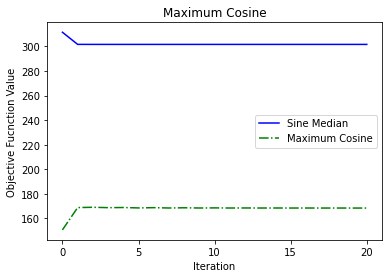

In [6]:
#convergence plots for last experiment
plt.figure()
plt.plot(s_err, label = 'Sine Median', color = 'blue', linestyle = 'solid')
plt.plot(c_err, label = 'Maximum Cosine', color = 'green', linestyle = 'dashdot')
plt.title('Maximum Cosine')
plt.legend()
plt.xticks([n for n in range(0,21,5)])
plt.xlabel('Iteration')
plt.ylabel('Objective Fucnction Value')


## With MNIST

In [7]:
'''
Shannon Stiverson's dataloader

Inputs:
    digits- list or int for digits from MNIST to be samples
    sample_size - number of samples of that digit
    dset - 'train' or 'test' for sampling from the training or the test datasets
Outputs:
    out_datamat - a numpy array of dimensions (784 x sample_size)
    datamat_labels - a list of labels of the sampled points
'''

def load_mnist_data(digits, sample_size=100, dset='train', shuffle = False):

    if type(digits) == int:
        digits = [digits]

    if type(sample_size) == int:
        sample_size = [sample_size]*len(digits)

    if len(sample_size) != len(digits):
        print('Incorrect number of sample sizes given.')
        return [], []

    return_data = []
    return_labels = []

    for i in range(len(digits)):
        digit = digits[i]
        size = sample_size[i]
        digit_data = np.loadtxt('../MNIST/%s%i.csv' % (dset, digit), delimiter=',')
        if digit_data.shape[1] < size:
            print('Sample number for digit %i reduced to %i' % (digit, digit_data.shape[1]))
            return_data.append(digit_data)
            return_labels.append([digit]*digit_data.shape[1])
        else:
            if shuffle:
                idx = np.random.choice(np.arange(digit_data.shape[1]), size)
            else:
                idx = np.arange(size)
            return_data.append(digit_data[idx, :])
            return_labels.append([digit]*size)

    datamat = return_data[0]
    datamat_labels = return_labels[0]

    if len(digits) > 1:
        for i in range(1, len(digits)):
            datamat = np.vstack((datamat, return_data[i]))
            datamat_labels = np.hstack((datamat_labels, return_labels[i]))

    out_datamat = datamat.T
    
    return out_datamat, datamat_labels


In [8]:
'''
calculates Flag Mean, Maximum Cosine and Sine Median for a dataset

Inputs:
    k- int for Gr(k,748)
    num_samples2- int for number of samples of 2s
    num_samples5- int for number of samples of 5s
    n_its- integer for the number of iterations of FlagIRLS
    seed- int for numpy random initialization
Outputs:
    flagmean- numpy array that represents Flag Mean of gr_list
    sin_median- numpy array that represents Sine Median of gr_list
    max_cosine- numpy array that represents Max Cosine of gr_list
    gr_list- dataset as subspaces in Gr(k,748)
'''
def run_test(k,num_samples2,num_samples5,n_its,seed):
    
    data_matrix2 = load_mnist_data(2, k*num_samples2, dset='train')[0]
    data_matrix5 = load_mnist_data(5, k*num_samples5, dset='train')[0]

    gr_list = []
    for i in range(num_samples2):
        if k==1:
            point = data_matrix2[:,:k]
            gr_list.append(point/np.linalg.norm(point))
        else:
            point = data_matrix2[:,i*k:(i+1)*k]
            gr_list.append(np.linalg.qr(point)[0][:,:k])

    for i in range(num_samples5):
        if k==1:
            point = data_matrix5[:,:k]
            gr_list.append(point/np.linalg.norm(point))
        else:
            point = data_matrix2[:,i*k:(i+1)*k]
            gr_list.append(np.linalg.qr(point)[0][:,:k])
            
    
    flagmean = ca.flag_mean(gr_list, k, fast = False)
    print('Flag Mean finished')

    #calculate sine median
    sin_median, s_err = ca.irls_flag(gr_list, k, n_its, 'sine', fast = False, seed = seed)
    print('Sine Median finished')

    #calculate maximum cosine
    max_cosine, c_err = ca.irls_flag(gr_list, k, n_its, 'cosine', fast = False, seed = seed)
    print('Max Cos finished')

    return flagmean, sin_median, max_cosine, gr_list

In [9]:
'''
creates an image of the plot_k row of each Y in Ys

Inputs:
    title- string for the plot title
    Ys- list of numpy arrays to be plotted
    plot_k - column to plot

Outputs:
    none
'''
def plot_results(title, Ys, plot_k):
    for Y in Ys:
        plt.figure()
        plt.title(title)
        plt.imshow(Y[:,plot_k].reshape(28,28), cmap = 'gray')
        plt.axis('off')

In [10]:

k = 1 #Gr(k,n)
num_samples2 = 50 #number of samples of the 2 digit
n_its = 20 #number of iterations for FlagIRLS
seed = 1 #for initialization
incr = 25 #samples 5s from 0 to num_samples2 in increments of incr

plot_k = 0 #the ith column of the outputs of FlagIRLS and FlagIRLS

if num_samples2 % incr != 0:
    print('incr does not divide num_samples2 evenly!')

In [11]:


flagmeans = []
sin_medians = []
max_cosines = []
for num_samples5 in range(0,num_samples2,incr):
    out = run_test(k,num_samples2,num_samples5,n_its,seed)
    flagmeans.append(out[0])
    sin_medians.append(out[1])
    max_cosines.append(out[2])
dataset = out[3]

Flag Mean finished
Sine Median finished
Max Cos finished
Flag Mean finished
Sine Median finished
Max Cos finished


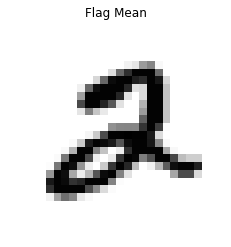

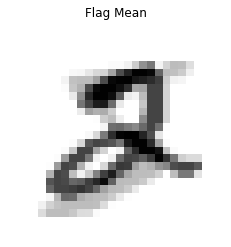

In [12]:
plot_results('Flag Mean', flagmeans, plot_k)

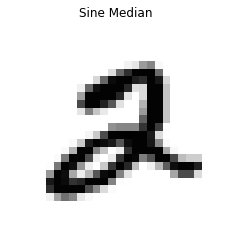

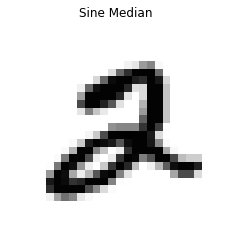

In [13]:
plot_results('Sine Median', sin_medians, plot_k)

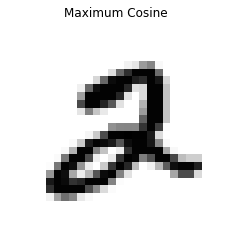

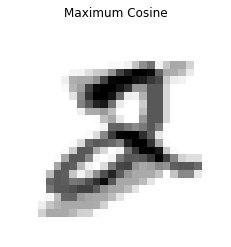

In [14]:
plot_results('Maximum Cosine', max_cosines, plot_k)

In [15]:
for sin_median in sin_medians:
    if not sanity_check(sin_median, 'sine', dataset):
        'Sine Median did not converge to optimizer'
for max_cosine in max_cosines:
    if not sanity_check(max_cosine, 'cosine', dataset):
        'Maximum Cosine did not converge to optimizer'
print('Check finished.')

Check finished.
